<a href="https://colab.research.google.com/github/nabnfikri/predict-customer-personality-to-boost-marketing-campaign-by-using-clustering/blob/main/Minpro_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [94]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

#package Vizualiation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# google drive auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set_style('darkgrid')
sns.set(font_scale=1.3)

sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Read Dataset

In [49]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Mini Project/3. Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning/marketing_campaign_data.csv')
df.head(5)

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

EDA

1. Dt_Customer dibuat berdasarkan tahun
2. Year_Birth diubah menjadi Age
3. Marital_Status ada beberapa value yang bernilai sama (bisa disatukan)
4. Mnt disum jadi revenue
5. AcceptedCmp disum

In [51]:
# membuang kolom Unnamed: 0
df = df.drop(['Unnamed: 0'], axis=1)
df.sample(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1106,6271,1952,S3,Menikah,50870000.0,0,1,19-06-2014,13,53000,0,8000,0,0,2000,1,2,0,3,5,0,0,0,0,0,0,3,11,0
362,2958,1978,S1,Menikah,28442000.0,2,0,24-02-2014,53,19000,3000,10000,11000,8000,6000,3,2,1,4,4,0,0,0,0,0,0,3,11,0
191,5602,1989,S3,Bertunangan,66973000.0,0,0,17-05-2013,98,466000,22000,432000,147000,113000,102000,1,8,7,12,3,0,0,0,0,0,0,3,11,0


In [52]:
# jumlah customer yang lahir di tahun di atas 1940, akan di drop saja
df[df['Year_Birth']<1940].shape[0]

3

In [53]:
df = df.loc[df.Year_Birth >= 1940]

# Feature Engineering

In [54]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

df['age'] = 2022 - df['Year_Birth']
df['join_at_age'] = df['Dt_Customer'].dt.year - df['Year_Birth']
df['total_kids'] = df['Kidhome'] + df['Teenhome']
df['is_parent'] = np.where(df['total_kids'] > 0, 1, 0)

# age_range
df.loc[(df['age'] >= 0) & (df['age'] < 12), 'age_range'] = 'child'
df.loc[(df['age'] >= 12) & (df['age'] < 18), 'age_range'] = 'teens'
df.loc[(df['age'] >= 18) & (df['age'] < 36), 'age_range'] = 'young_adults'
df.loc[(df['age'] >= 36) & (df['age'] < 55), 'age_range'] = 'middle_age'
df.loc[(df['age'] >= 55), 'age_range'] = 'elderly'

# amount_spent
df['total_spent'] = df['MntCoke'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# accepted_campaigns
df['total_acc_campaign'] = df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['AcceptedCmp1'] + df['AcceptedCmp2']

# total transastion purchased (assumed these transastions are MECE -> Mutually exclusive and collectively exhaustive)
df['total_transaction'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

def feat_eng(x, y):
  if y == 0:
    return 0
  return x / y

df['cvr'] = df.apply(lambda x: feat_eng(x['total_transaction'], x['NumWebVisitsMonth']), axis=1)

# Exploratory Analysis

Rate Analysis based on Income, Age, and Spending

## Statictical Summary

In [55]:
nums = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 
        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Z_CostContact', 
        'Z_Revenue', 'age', 'join_at_age', 'total_kids', 'total_spent']

cats = ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'is_parent', 'age_range']

In [56]:
df[nums].describe()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,age,join_at_age,total_kids,total_spent
count,2.213000e+03,2237.000000,2237.000000,2237.000000,2.237000e+03,2237.000000,2.237000e+03,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.0,2237.0,2237.000000,2237.000000,2237.000000,2.237000e+03
mean,5.223658e+07,0.444345,0.506482,49.104604,3.039955e+05,26270.451498,1.669169e+05,37523.021904,27068.842199,43968.708091,2.326777,4.087170,2.662494,5.794367,5.319177,3.0,11.0,53.098346,44.126062,0.950827,6.057434e+05
std,2.517860e+07,0.538467,0.544593,28.956073,3.365744e+05,39715.971567,2.256612e+05,54639.909469,41293.949311,52054.317516,1.932923,2.779461,2.923456,3.250940,2.426386,0.0,0.0,11.701917,11.739008,0.752037,6.018405e+05
min,1.730000e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,26.000000,16.000000,0.000000,5.000000e+03
25%,3.524600e+07,0.000000,0.000000,24.000000,2.400000e+04,1000.000000,1.600000e+04,3000.000000,1000.000000,9000.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0,45.000000,36.000000,0.000000,6.900000e+04
50%,5.137300e+07,0.000000,0.000000,49.000000,1.740000e+05,8000.000000,6.700000e+04,12000.000000,8000.000000,24000.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0,52.000000,43.000000,1.000000,3.960000e+05
75%,6.848700e+07,1.000000,1.000000,74.000000,5.040000e+05,33000.000000,2.320000e+05,50000.000000,33000.000000,56000.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0,63.000000,54.000000,1.000000,1.045000e+06
max,6.666660e+08,2.000000,2.000000,99.000000,1.493000e+06,199000.000000,1.725000e+06,259000.000000,263000.000000,362000.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0,82.000000,73.000000,3.000000,2.525000e+06


In [57]:
df[cats].describe()

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,is_parent
count,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000
mean,0.072865,0.074654,0.072418,0.064372,0.013411,0.008941,0.149307,0.715244
std,0.259974,0.262890,0.259237,0.245469,0.115052,0.094152,0.356471,0.451399
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Bivariate Analysis

### Correlation Heatmap

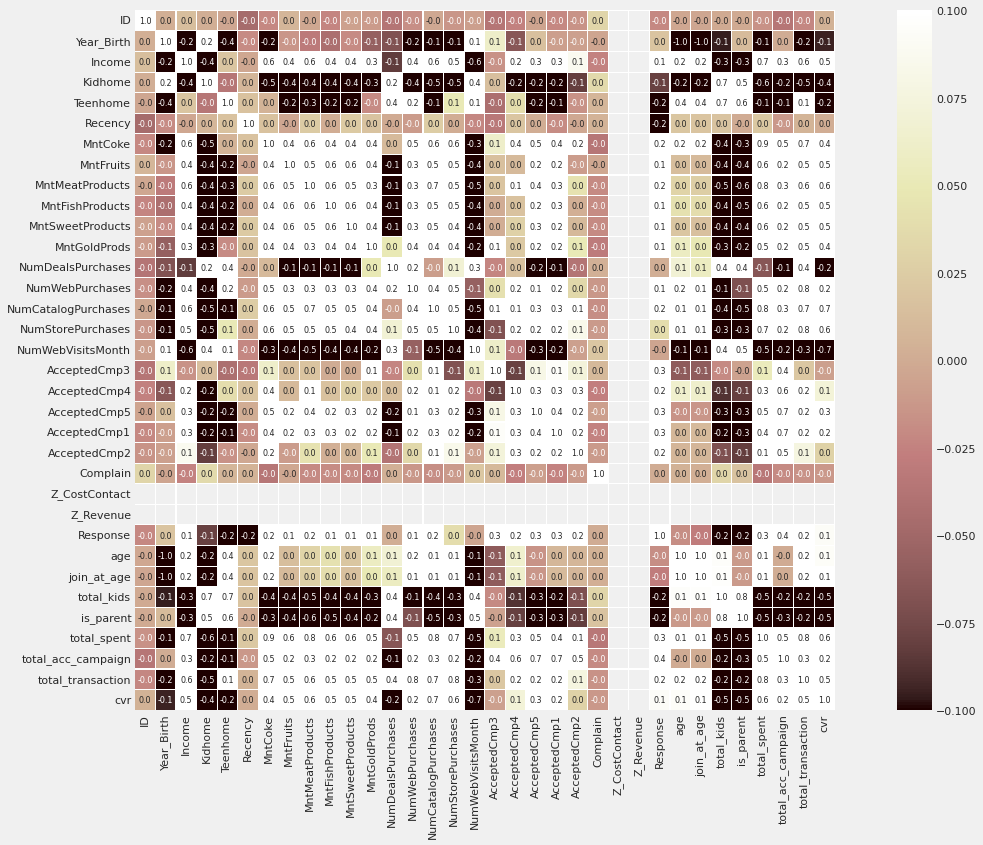

In [58]:
plt.figure(figsize=(20, 12))
corrmat = df.corr()
sns.heatmap(corrmat, cmap='pink', annot=True, fmt='.1f',
           vmin=corrmat.values.min(), vmax=1, square=True, linewidths=0.1, annot_kws={"fontsize":8});

### Income vs Spending

(0.0, 120000000.0)

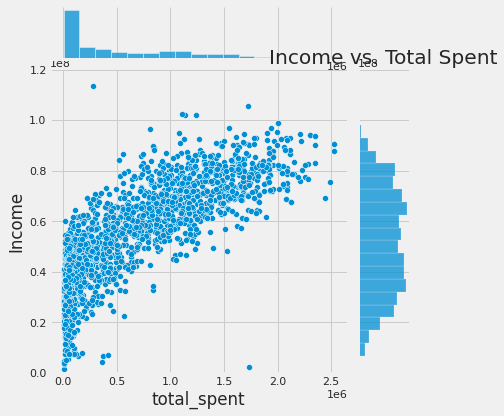

In [59]:
plot = sns.jointplot(x=df["total_spent"], y=df["Income"])
plt.title('Income vs. Total Spent')
plot.ax_marg_y.set_ylim(0, 120000000)

### Income vs CVR

(0.0, 120000000.0)

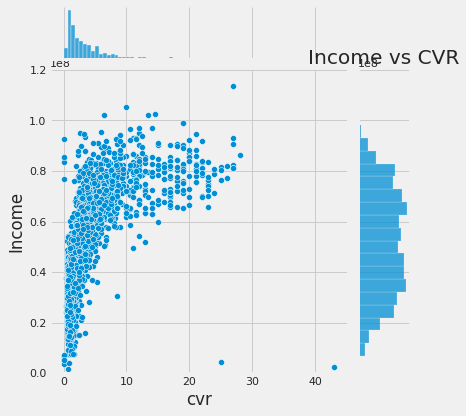

In [60]:
plot = sns.jointplot(x=df['cvr'], y=df['Income'])
plt.title('Income vs CVR')
plot.ax_marg_y.set_ylim(0, 120000000)

### Age vs Spending & Income

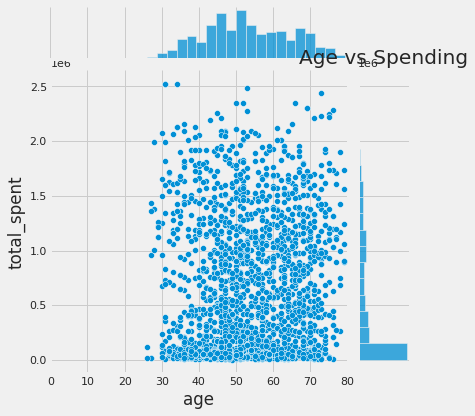

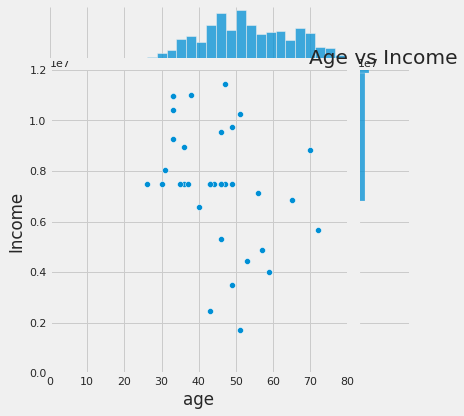

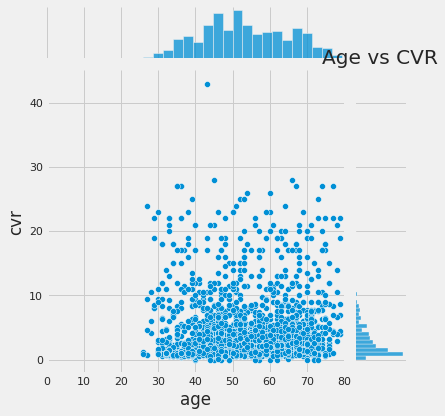

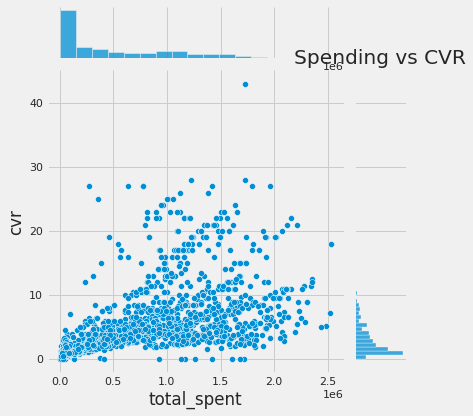

In [61]:
plot = sns.jointplot(x=df['age'], y=df['total_spent'])
plt.title('Age vs Spending')
plot.ax_marg_x.set_xlim(0, 80)
plt.show()

plot = sns.jointplot(x=df['age'], y=df['Income'])
plt.title('Age vs Income')
plot.ax_marg_x.set_xlim(0, 80)
plot.ax_marg_y.set_ylim(0, 12000000)
plt.show()

plot = sns.jointplot(x=df['age'], y=df['cvr'])
plt.title('Age vs CVR')
plot.ax_marg_x.set_xlim(0, 80)
plt.show()

plot = sns.jointplot(x=df['total_spent'], y=df['cvr'])
plt.title('Spending vs CVR')
plt.show()

# Data Cleaning

## Cek Missing Value

In [62]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntCoke                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
age                     0
join_at_age             0
total_kids              0
is_parent               0
age_range               0
total_spent             0
total_acc_campaign      0
total_transaction       0
cvr                     0
dtype: int64

In [63]:
# double cek
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntCoke                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
age                     0
join_at_age             0
total_kids              0
is_parent               0
age_range               0
total_spent             0
total_acc_campaign      0
total_transaction       0
cvr                     0
dtype: int64

In [64]:
df['Income'].describe()

count    2.213000e+03
mean     5.223658e+07
std      2.517860e+07
min      1.730000e+06
25%      3.524600e+07
50%      5.137300e+07
75%      6.848700e+07
max      6.666660e+08
Name: Income, dtype: float64

## Handling Missing Value

In [65]:
# dikarenakan missing value nya hanya sedikit dan di kolom Income tidak memiliki Income = 0, maka missing value akan diisi menggunakan angka 0
df['Income'] = df['Income'].fillna(0)

In [66]:
df.isna().sum()

#sudah bersih

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntCoke                0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
age                    0
join_at_age            0
total_kids             0
is_parent              0
age_range              0
total_spent            0
total_acc_campaign     0
total_transaction      0
cvr                    0
dtype: int64

## Check Duplicate Rows

In [67]:
df.duplicated().sum()

0

Tidak ada baris duplikat

# Feature Engineering

## Feature Encoding

In [68]:
for col in cats:
    print(f'value counts of column {col}')
    print(df[col].value_counts())
    print('---'*10, '\n')

value counts of column Education
S1     1127
S3      485
S2      370
D3      201
SMA      54
Name: Education, dtype: int64
------------------------------ 

value counts of column Marital_Status
Menikah        864
Bertunangan    579
Lajang         483
Cerai          231
Janda           77
Duda             3
Name: Marital_Status, dtype: int64
------------------------------ 

value counts of column AcceptedCmp3
0    2074
1     163
Name: AcceptedCmp3, dtype: int64
------------------------------ 

value counts of column AcceptedCmp4
0    2070
1     167
Name: AcceptedCmp4, dtype: int64
------------------------------ 

value counts of column AcceptedCmp5
0    2075
1     162
Name: AcceptedCmp5, dtype: int64
------------------------------ 

value counts of column AcceptedCmp1
0    2093
1     144
Name: AcceptedCmp1, dtype: int64
------------------------------ 

value counts of column AcceptedCmp2
0    2207
1      30
Name: AcceptedCmp2, dtype: int64
------------------------------ 

value counts o

### Label Encoding

In [69]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'age', 'join_at_age', 'total_kids', 'is_parent', 'age_range', 'total_spent', 'total_acc_campaign', 'total_transaction', 'cvr'], dtype='object')

In [70]:
mapping_education = {
    'SMA' : 0,
    'D3' : 1,
    'S1' : 2,
    'S2' : 3,
    'S3' :4
}

df['edu_mapped'] = df['Education'].map(mapping_education)

### One Hot Encoding

In [71]:
dataset_cats = df[['Education']].copy()

# One hot encoder
for cat in ['Marital_Status', 'age_range', 'is_parent']:
  onehots = pd.get_dummies(df[cat], prefix=cat)
  dataset_cats = dataset_cats.join(onehots)

## Feature Standardization

In [72]:
dataset_scaled = df.copy()
ss = StandardScaler()

for col in nums:
  dataset_scaled[col] = ss.fit_transform(dataset_scaled[[col]])

display(dataset_scaled.shape, dataset_scaled.sample(3))

(2237, 39)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,join_at_age,total_kids,is_parent,age_range,total_spent,total_acc_campaign,total_transaction,cvr,edu_mapped
512,5389,1964,S1,Menikah,-0.107623,-0.825388,2.743062,2013-10-20,1.516269,-0.196124,-0.233471,-0.438440,-0.540441,-0.413442,-0.729569,0.348371,0.688356,-0.226664,-0.244405,0.692882,0,1,0,0,0,0,0.0,0.0,0,0.418970,0.415284,1.395420,1,elderly,-0.430016,1,16,2.285714,2
777,4964,1958,S3,Bertunangan,0.881470,-0.825388,-0.930227,2014-01-26,1.412641,1.117401,-0.384577,0.997662,0.686044,-0.655663,-0.844859,-0.686563,-0.751094,2.852573,-0.552077,-1.780485,0,0,0,0,0,0,0.0,0.0,0,0.931821,1.011720,-1.264618,0,elderly,0.917818,0,18,18.000000,4
794,4442,1961,S1,Lajang,-0.201183,-0.825388,0.906417,2013-05-04,0.721785,-0.811281,-0.183102,-0.584710,-0.210937,-0.316554,0.154321,-0.169096,-1.110957,-0.568802,-0.244405,-0.956029,0,0,0,0,0,0,0.0,0.0,0,0.675395,0.670900,0.065401,1,elderly,-0.712546,0,9,3.000000,2


In [73]:
df.sample(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,join_at_age,total_kids,is_parent,age_range,total_spent,total_acc_campaign,total_transaction,cvr,edu_mapped
2016,7042,1983,S1,Menikah,36790000.0,0,0,2013-01-03,14,3000,3000,14000,15000,21000,10000,1,2,1,2,9,0,0,0,0,0,0,3,11,1,39,30,0,0,middle_age,66000,0,6,0.666667,2
658,3867,1947,S3,Bertunangan,73059000.0,0,1,2013-08-31,36,410000,112000,420000,0,82000,71000,1,9,3,13,4,0,0,0,0,0,0,3,11,0,75,66,1,1,elderly,1095000,0,26,6.500000,4
1887,5113,1971,S3,Cerai,86979000.0,0,0,2013-07-11,67,584000,100000,835000,65000,83000,35000,1,5,5,5,2,1,0,0,0,0,0,3,11,1,51,42,0,0,middle_age,1702000,1,16,8.000000,4


# K-Means

[105798.35259543237, 78938.2853259697, 62396.64836294312, 56065.93661315694, 50957.79364178052, 47505.911394980285, 44466.11999883051, 41911.89303112251, 40688.37890967599, 39279.18623684297, 38216.01485918798, 37218.7563114864, 36371.76703783666, 35587.68036172129, 34826.98992051887, 34361.36599764631, 33686.23688460936, 33171.173354950064]


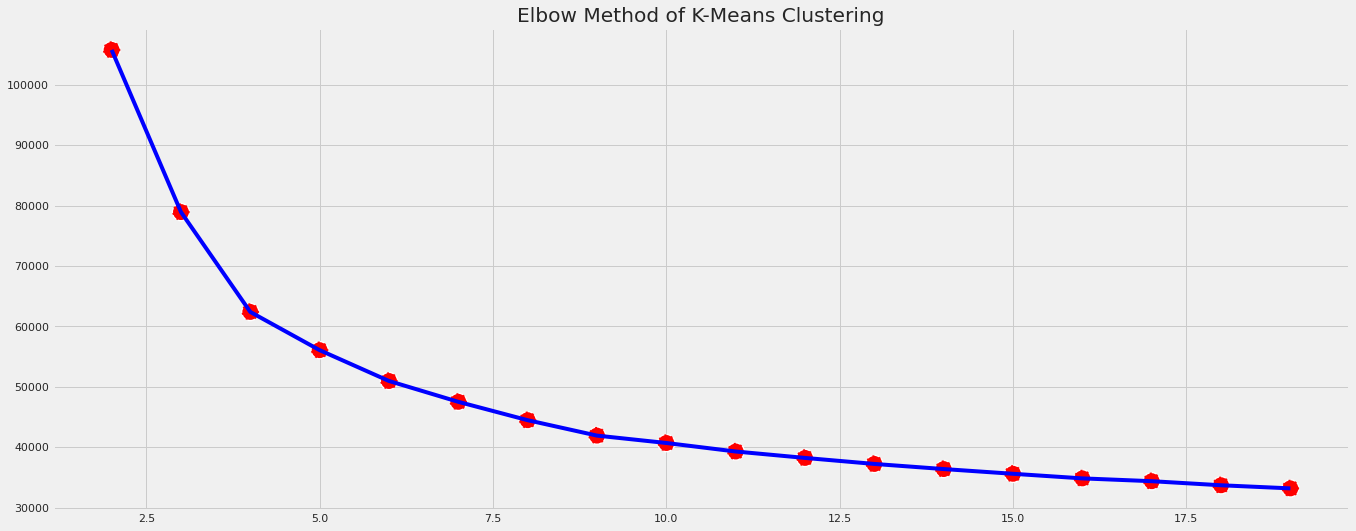

In [74]:
X = dataset_scaled.drop(columns=['ID', 'Year_Birth', 'Education', 'Marital_Status', 'age_range', 'Dt_Customer']).copy()
inertia = []

for i in range(2, 20):
  kmeans = KMeans(n_clusters=i, random_state=19)
  kmeans.fit(X.values)
  inertia.append(kmeans.inertia_)

print(inertia)
plt.title('Elbow Method of K-Means Clustering')

sns.lineplot(x=range(2, 20), y=inertia, color='blue', linewidth=4)
sns.scatterplot(x=range(2, 20), y=inertia, s=300, color='red', linestyle='--');

Pada visualisasi tersebut, jumlah cluster yang dipilih adalah sejumlah 4 cluster, karena pada cluster 4 ke 5 memiliki selisih jarak yang sedikit. Selain itu, pada cluster selanjutnya juga memiliki selisih jarak yang kecil

In [75]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=19)
kmeans.fit(X.values)
X['cluster'] = kmeans.labels_
df['cluster'] = kmeans.labels_

In [76]:
X.sample(3)

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,join_at_age,total_kids,is_parent,total_spent,total_acc_campaign,total_transaction,cvr,edu_mapped,cluster
1533,-0.217817,1.032151,0.906417,1.274470,-0.734015,-0.661606,-0.620169,-0.686886,-0.655663,-0.153119,0.865837,-0.391232,-0.226664,-1.167421,1.105110,0,0,0,0,0,0,0.0,0.0,1,-0.521257,-0.607177,1.395420,1,-0.807277,0,11,1.375,3,0
2080,-0.932205,1.032151,-0.930227,-0.314498,-0.879632,-0.006811,-0.535954,0.008731,-0.437664,0.096676,-0.169096,-0.391232,-0.910939,-0.552077,1.105110,0,0,0,0,0,0,0.0,0.0,0,-0.350307,-0.436767,0.065401,1,-0.714208,0,9,1.125,2,0
27,-2.017864,1.032151,-0.930227,-1.039897,-0.888548,-0.636422,-0.726547,-0.631969,5.714733,6.110971,-1.204030,8.245467,-0.910939,-1.782765,-1.780485,0,0,0,0,0,0,0.0,0.0,0,-1.461484,-1.459228,0.065401,1,0.051947,0,27,27.000,2,3


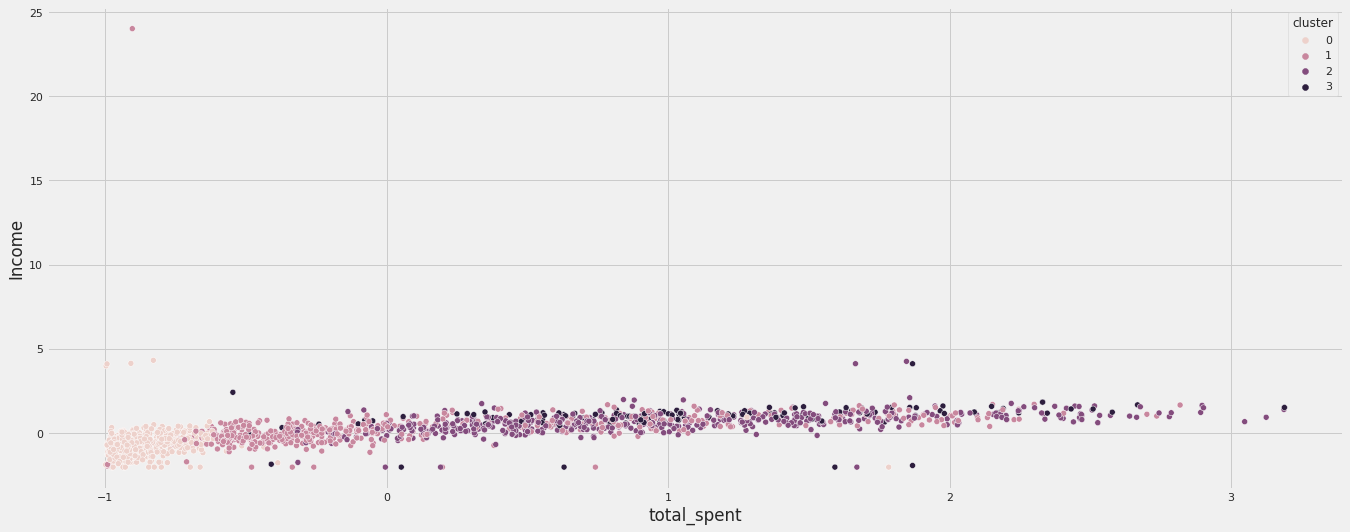

In [77]:
sns.scatterplot(data=X, x='total_spent', y='Income', hue='cluster');

# Silhouette Score

## Calculating the silhouette score:

In [78]:
def visualize_silhouette_layer(data):
  clusters_range = range(2, 10)
  results = []

  for i in clusters_range:
    km = KMeans(n_clusters=i, random_state=19)
    cluster_labels = km.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    results.append([i, silhouette_avg])

  result = pd.DataFrame(results, columns=['n_clusters', 'silhouette_score'])
  pivot_km = pd.pivot_table(result, index='n_clusters', values='silhouette_score')

  plt.figure()
  sns.heatmap(pivot_km, annot=True, linewidth=1, fmt='.3f', cmap='autumn_r')
  plt.tight_layout()
  plt.title('Silhouette Score of K-Means Clustering')
  plt.show()

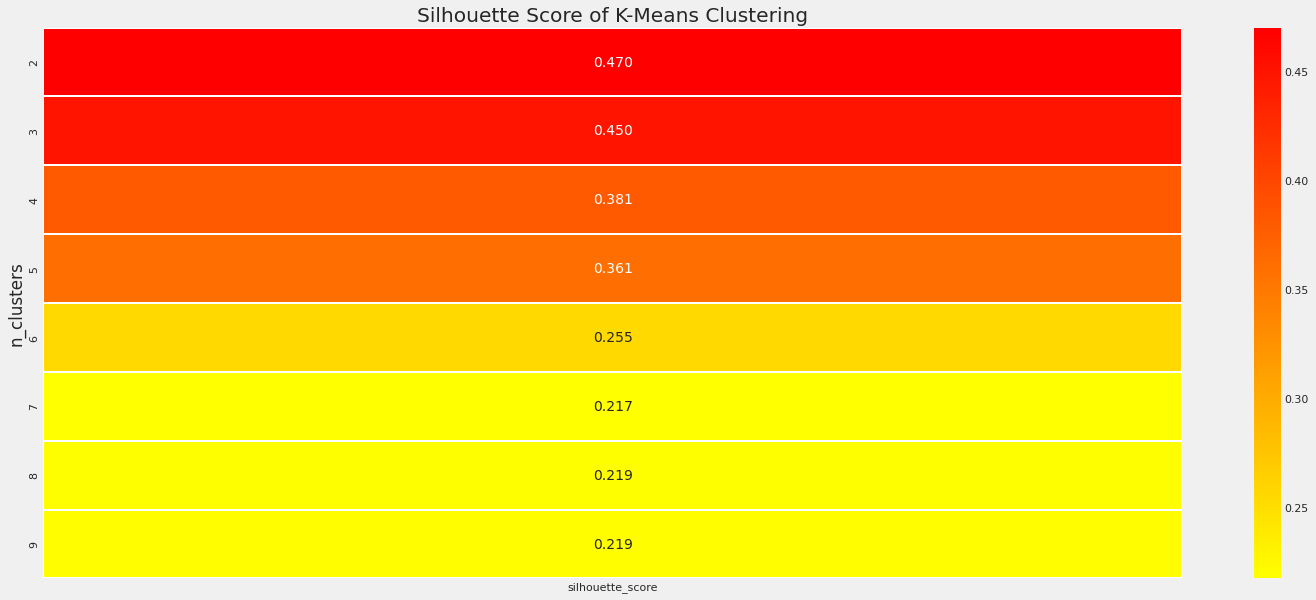

In [79]:
visualize_silhouette_layer(X)

# Customer Personality Analysis for Marketing Targeting

## Cluster Analysis & Interpretation

In [81]:
df[nums+['cluster']].groupby('cluster')['Income', 'total_spent'].describe().reset_index()

cluster Income                                                                                   total_spent                                                                                  
           count          mean           std  min         25%         50%         75%          max       count          mean            std       min       25%        50%        75%        max
0       0  930.0  3.335299e+07  1.477735e+07  0.0  24383750.0  33249000.0  41018500.0  162397000.0       930.0  7.869462e+04   89331.443849    5000.0   36000.0    57000.0    96750.0  1679000.0
1       1  609.0  5.877203e+07  2.938750e+07  0.0  47009000.0  57288000.0  68805000.0  666666000.0       609.0  7.207734e+05  491488.851016    8000.0  353000.0   507000.0  1044000.0  2302000.0
2       2  559.0  6.815759e+07  1.407653e+07  0.0  60204000.0  68117000.0  76597500.0  160803000.0       559.0  1.189556e+06  443492.917302  415000.0  835500.0  1112000.0  1495000.0  2524000.0
3       3  139.0  7.689940e+07  1.814054e+07  0.0  72407000.0  79865000.0  83829000.0  157146000.0       139.0  1.280209e+06  431701.931437  277000.0  984500.0  1208000.0  1569000.0  2525000.0

In [82]:
# mapping cluster
map_cluster = {
    0 : 'Low Spender',
    1 : 'Risk of Churn',
    2 : 'Mid Spender',
    3 : 'High Spender'
}

df['cluster_mapped'] = df['cluster'].map(map_cluster)

### Boxplot User per Cluster

''

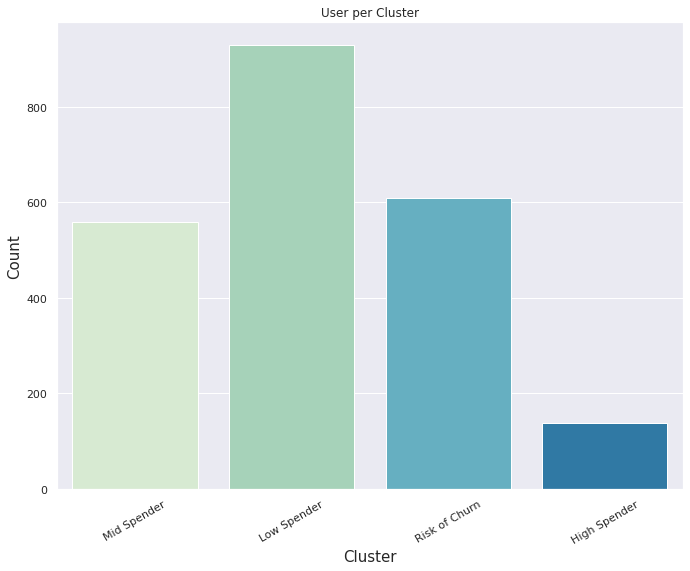

In [89]:
sns.set(rc={'figure.figsize':(10,8)})
sns.countplot(x=df['cluster_mapped'], palette='GnBu')
plt.title('User per Cluster')
plt.xticks(rotation=30)
plt.xlabel('Cluster', fontsize=15) #mengatur title dan ukurannya di x-axis
plt.ylabel('Count', fontsize=15) #mengatur title dan ukurannya di y-axis
;

### Plot Income vs Total Spent per Cluster

(0.0, 120000000.0)

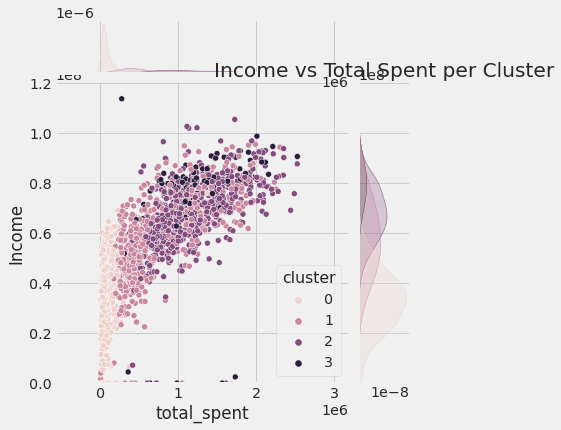

In [96]:
plot = sns.jointplot(x=df['total_spent'], y=df['Income'], hue=df['cluster'])
plt.title('Income vs Total Spent per Cluster')
plot.ax_marg_y.set_ylim(0, 120000000)

### Total Income per Cluster

(0.0, 120000000.0)

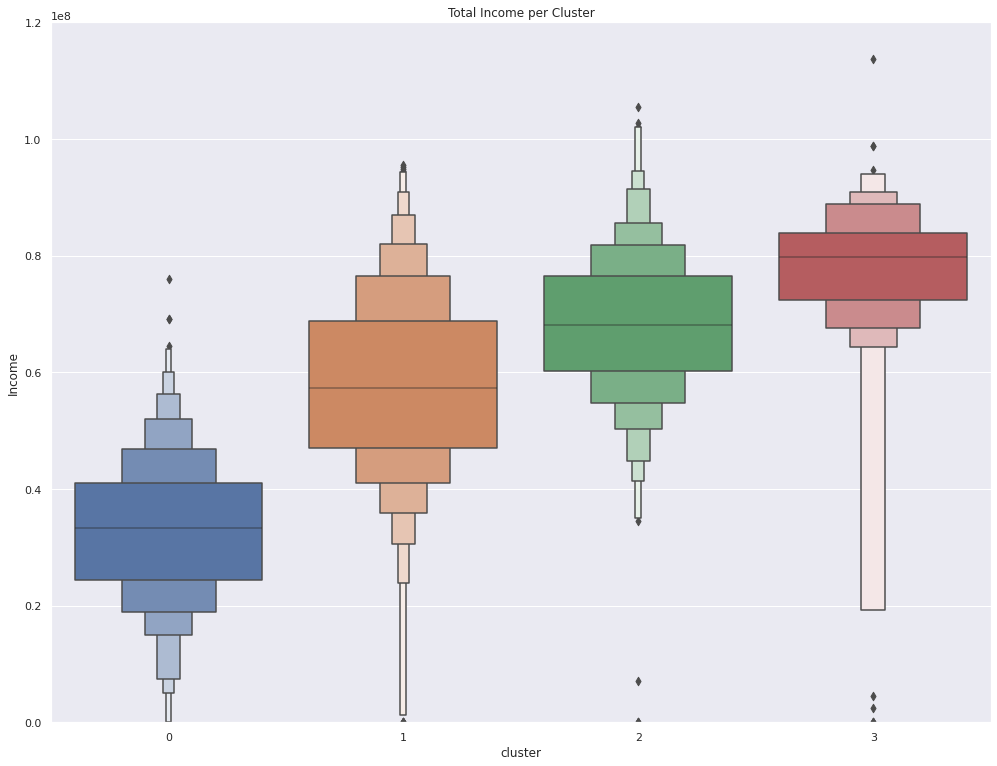

In [99]:
sns.set(rc={'figure.figsize':(15,12)})
sns.boxenplot(x=df['cluster'], y=df['Income'])
plt.title('Total Income per Cluster')
plt.ylim(0, 120000000)

### Total Spending per Cluster

Text(0.5, 1.0, 'Total Amount Spent per Cluster')

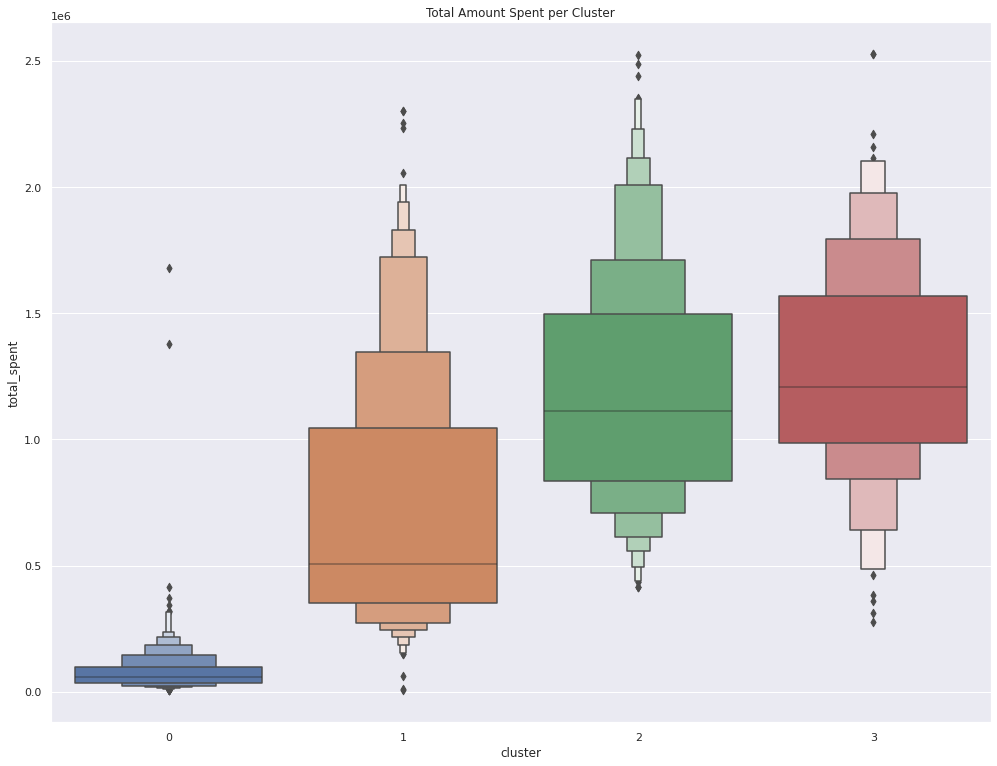

In [100]:
sns.boxenplot(x=df['cluster'], y=df['total_spent'])
plt.title('Total Amount Spent per Cluster')

### Total Visits per Cluster

Text(0.5, 1.0, 'Total Visit Web per Cluster')

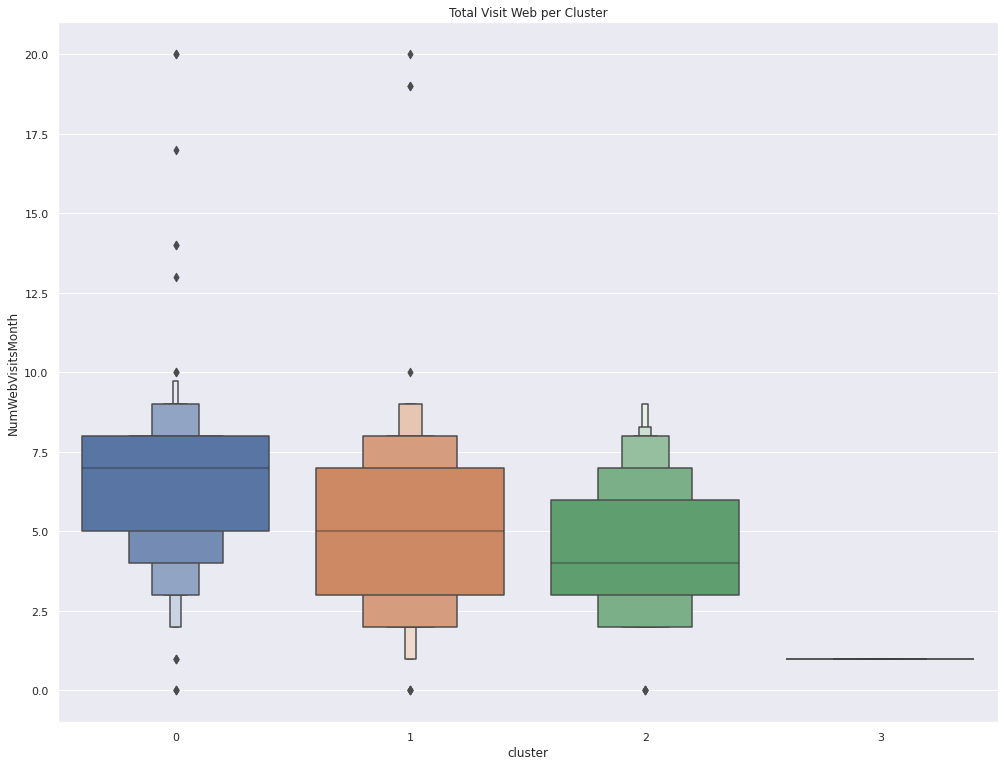

In [101]:
sns.boxenplot(x=df['cluster'], y=df['NumWebVisitsMonth'])
plt.title('Total Visit Web per Cluster')

### Deal Purchased per Cluster

Text(0.5, 1.0, 'Deal Purchases per Cluster')

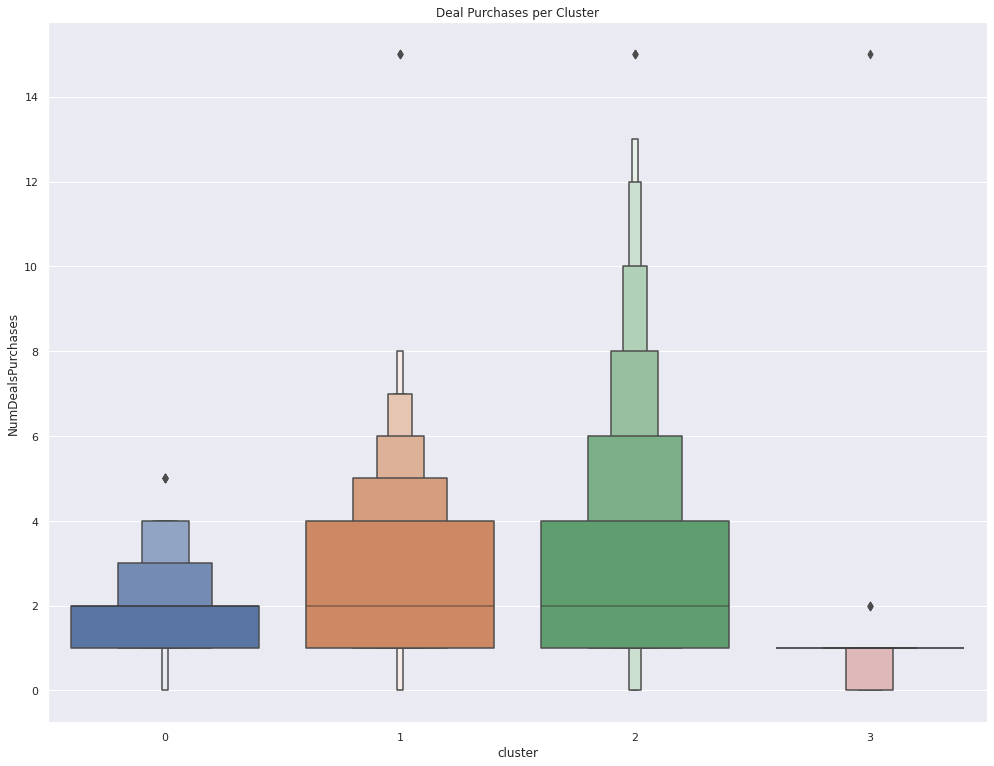

In [102]:
sns.boxenplot(x=df['cluster'], y=df['NumDealsPurchases'])
plt.title('Deal Purchases per Cluster')

### Conversion per Cluster

Text(0.5, 1.0, 'CVR per Cluster')

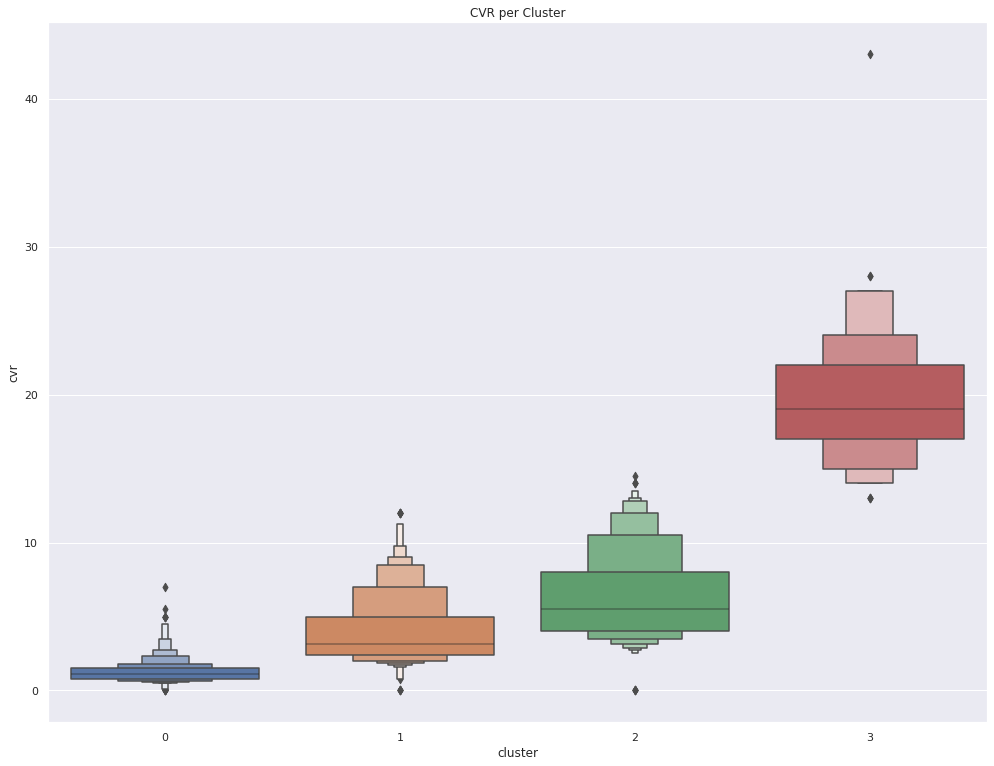

In [103]:
sns.boxenplot(x=df['cluster'], y=df['cvr'])
plt.title('CVR per Cluster')

# Rekomendation & Potential Impact

## Recommendation

1. Tetap monitor transaksi dan retensi dari kelompok High Spender, Fokus untuk tingkatkan service agar kelompok kelompok ini tidak churn
2. Untuk kelompok Mid Spender dapat dilakukan analisis lebih lanjut bagaimana agar meningkatkan transaksinya dengan memberikan rekomendasi yang lebih personal, serta analisis lebih dalam bagaimana untuk optimasi promo pada segmen ini dan tetap berbelanja di platform kita
3. Untuk kelompok Low Spender dan Risk to Churn, juga dapat dilakukan analisis lebih lanjut bagaimana meningkatkan rasio konversi visit to transaction, Mereka mempunyai jumlah visit yang cukup tinggi tapi tidak melakukan transaksi. Hal ini dapat disebabkan oleh produk ataupun harga yang tidak cocok.

## Potential Impact

1. Jika kita fokus untuk terus monitor kelompok High Spender, kita akan tetap mendapatkan potensial GMV sebesar IDR 177 Juta, sedangkan untuk kelompok Mid Spender sebesar IDR 66 Juta
2. Jika kita dapat optimasi promo yang di spend untuk Mid Spender (dengan asumsi reduksi 50%) kita dapat melakukan reduksi cost sebesar IDR 40 Juta

In [104]:
df[df.cluster == 3].total_spent.sum()

177949000

In [105]:
df[df.cluster == 3].total_spent.sum() / df[df.cluster == 3].total_transaction.sum()

65663.83763837638

In [106]:
df[df.cluster == 2].total_spent.sum()

664962000

In [107]:
df[df.cluster == 2].total_spent.sum() / df[df.cluster == 2].total_transaction.sum()

48350.32356576747

In [108]:
#jumlah yang dapat disave jika dapat optimasi promo cost (asumsi: target reduce 50%)
(df[df.cluster == 2].total_spent.sum() / df[df.cluster == 2].total_transaction.sum()) * df[df.cluster == 2].NumDealsPurchases.sum()

80599989.38413437

In [110]:
80599989*0.5

40299994.5